(<Figure size 400x200 with 1 Axes>, <Axes: >)

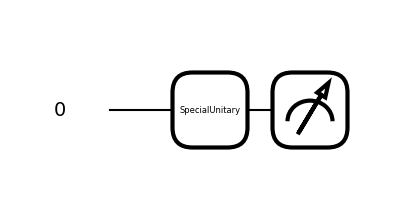

In [1]:
import pennylane as qml
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

dev = qml.device('default.qubit', wires = 1)
#Define Hamiltonian
obs = [qml.Z(0),qml.Y(0)]
coeff = [0.6,-0.8]
H = qml.Hamiltonian(coeff,obs)

def qfunc(theta):
    qml.SpecialUnitary(theta,wires = 0)
    return qml.expval(H)

circuit = qml.QNode(qfunc,dev,interface='jax',diff_method='parameter-shift')
 # For 1 qubit, only 3 parameters are required. 
theta = jnp.array([0.4,0.2,-0.5])
theta = np.array([0.4,0.2,-0.5])

qml.draw_mpl(circuit,decimals=2)(theta)


In [2]:
# we will apply finite difference approach to compute the gradient wrt second parameter

def fin_diff(weights,idx,delta):   
    new_weights = weights.reshape(-1)
    s = delta
    def gradient(weights,idx):
        weights_1 = weights.copy()
        weights_1[idx] += s/2
        plus_eval = circuit(weights_1)
        weights_1[idx] -= s
        minus_eval = circuit(weights_1)
        return (plus_eval-minus_eval)/(s)
    return gradient(weights,idx)

fin_diff(theta,1,0.75)
qml.ops.qubit.special_unitary.pauli_basis_matrices(3)
qml.SpecialUnitary


pennylane.ops.qubit.special_unitary.SpecialUnitary

In [3]:
#Stochastic Parameter-Shift Rule

num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

coefficients = np.random.randn(4**num_wires - 1)
# Create the matrices for the entire Pauli basis
basis = qml.ops.qubit.special_unitary.pauli_basis_matrices(num_wires)
# Construct the Hamiltonian from the normal random coefficients and the basis
H_matrix = qml.math.tensordot(coefficients, basis, axes=[[0], [0]])
H = qml.Hermitian(H_matrix, wires=wires)
# # Compute the ground state energy
E_min = min(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")


Ground state energy: -119.70320


In [6]:
#num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Initialize parameters for different circuit repetitions
repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 3, d) for rep in repetitions]
init_params_list = [np.random.randn(*shape) for shape in param_shapes] # give same initial parameters for each repetitions
init_params_list = [np.zeros(shape) for shape in param_shapes] # give same initial parameters for each repetitions



# Define the quantum circuit function
def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                operation(params_op, wires_op)
    return qml.expval(H)

# Create QNodes for different circuit repetitions
qnodes = [qml.QNode(circuit, dev, interface="jax") for _ in repetitions]


print(qml.draw(qnodes[1])(init_params_list[1], qml.SpecialUnitary))

0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)
2: ─╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)
3: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)
4: ─╭SpecialUnitary(M0)─╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)
5: ─╰SpecialUnitary(M0)─────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)

──────────────────────╭SpecialUnitary(M0)─╭SpecialUnitary(M0)────────────────────
──╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)
──╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)
──╭SpecialUnitary(M0)─│───────────────────╰SpecialUnitary(M0)─╭SpecialUnitary(M0)
──╰SpecialUnitary(M0)─│───────────────────╭SpecialUnitary(M0)─╰SpecialUnitary(M0)
──────────────────────╰SpecialUnitary(M0)─╰SpecialUnitary(M0)────────────────────

──

In [7]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_12776\391022573.py:24: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [9]:
learning_rate = 5e-4
num_steps = 3000
#grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)

# Define a function to run optimization for each circuit repetition
def optimize(i, operation): # i stands for repetition index
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    params = init_params_list[i]
    #qnode
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies

In [11]:
import matplotlib.pyplot as plt
import numpy as np
repetitions = [2, 4, 6, 8, 10]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, rep in enumerate(repetitions):
    ax = axes[i]
    
    # Plot for two_qubit_decomp
    e = optimize(i, two_qubit_decomp)  # Placeholder for two_qubit_decomp
    error = (e - E_min) / abs(E_min)
    ax.plot(np.arange(num_steps + 1), error, color="red", label=f"two_qubit_decomp, Repetitions = {rep}")

    # Plot for qml.SpecialUnitary
    e_1 = optimize(i, qml.SpecialUnitary)  # Placeholder for qml.SpecialUnitary
    error_1 = (e_1 - E_min) / abs(E_min)
    ax.plot(np.arange(num_steps + 1), error_1, color="green", label=f"SpecialUnitary, Repetitions = {rep}")

    #ax.set_yscale('log')  # Set y-axis to logarithmic scale
    ax.set_title(f"Energy (Random Hamiltonian) for two_qubit_decomp and SpecialUnitary (Rep = {rep})")
    ax.set_xlabel("Step")
    ax.set_ylabel("Relative Error (log scale)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()